In [1]:
import numpy as np
import networkx as nx
import torch
from torch_geometric.data import Data
import time

import random
from torch_geometric.utils import from_networkx

import matplotlib.pyplot as plt

from torch_geometric.nn import SAGEConv

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch.nn.functional as F

import sys
sys.path.insert(1,'../src')
from DataLoader_rad import RGGDataset_rad
from TwoLayerGraphSage import GCN, cGCN

import os.path as osp

from torch_geometric.data import Dataset, download_url

import os

/home/math/maskey/anaconda3/envs/pyg_cuda102/lib/python3.8/site-packages/torch_geometric/data/storage.py:244: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
07:40:49|TQ-INFO| Initializing torchquad.


In [2]:
DL = RGGDataset_rad(root = '//home/groups/ai/maskey/input_rad')

dataset = DL.get(5,50)

In [3]:
positions = torch.load('//home/groups/ai/maskey/input_rad/raw/positions_1000_10.pt')

In [4]:
model = GCN()
model.load_state_dict(torch.load( '../models/GCNTwoLayersGraphSage'))

cGCNN = cGCN()
cGCNN.load_state_dict(torch.load( '../models/cGCNTwoLayersGraphSage'))

<All keys matched successfully>

radius = 5 #give radius divided by 10
L2Errors = [] start = time.time()

lowpass = lambda x: (1+(torch.tensor(x[:,0]2 + x[:,1]2))).pow(-1)

low_pass = lambda x:  (1+(torch.tensor(x[:,0]**2 + x[:,1]**2))).pow_(-1)
#low_pass = lambda x:  x[:,0]*x[:,1]

y = torch.rand(1000,1)

cdata = DL.get(1,1000)
cpos = positions[99]
signal = low_pass(cpos[0])
signal = torch.reshape(signal,( len(signal),1))
cdata.x = signal 
#cdata.x = y 

output = model.forward(cdata)

for i in range(10, 1010, 10):
    data = DL.get(radius, i) 
    pos = positions[int((i-10)/10)]
    signal = cdata.x[pos[1].type(torch.LongTensor)]
    signal = torch.reshape(signal,( len(signal),1))
    data.x = signal
    
    nodeErrors = output[pos[1].type(torch.LongTensor)] - model.forward(data)
    L2Error = torch.sqrt(1/len(nodeErrors)*torch.sum(torch.pow(nodeErrors,2)))
    L2Errors.append(L2Error)

err = [x.detach().numpy() for x in L2Errors]

In [5]:
def error_fct(radius, signal):
    L2Errors = []

    cdata = DL.get(radius,1000)
    cpos = positions[99]

    cdata.x = signal 

    output = model.forward(cdata)

    for i in range(10, 1010, 10):
        data = DL.get(radius, i) 
        pos = positions[int((i-10)/10)]
        signal = cdata.x[pos[1].type(torch.LongTensor)]
        signal = torch.reshape(signal,( len(signal),1))
        data.x = signal + (0.01**0.5)*torch.randn(len(signal),1) #random noise

        nodeErrors = output[pos[1].type(torch.LongTensor)] - model.forward(data)
        L2Error = torch.sqrt(1/len(nodeErrors)*torch.sum(torch.pow(nodeErrors,2)))
        L2Errors.append(L2Error)

    err = [x.detach().numpy() for x in L2Errors]

    return err

In [6]:
errs = [ ]
#low_pass = lambda x:  (1+(torch.tensor(x[:,0]**2 + x[:,1]**2))).pow_(-1)
low_pass = lambda x:  x[:,0]*x[:,1]

cdata = DL.get(1,1000)
cpos = positions[99]
signal = low_pass(cpos[0])
signal = torch.reshape(signal,( len(signal),1))
#cdata.x = y 

#y = torch.randn(1000,1)

for i in [1,5,9]:
    errs.append(error_fct(i, signal))

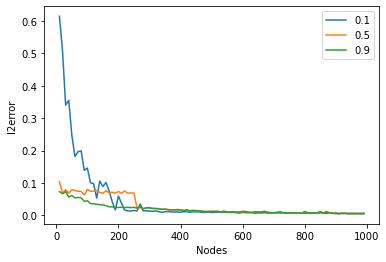

In [7]:
xAxis = list(range(10,1000,10))
fig = plt.figure()
plt.xlabel('Nodes')
plt.ylabel('l2error')
#txt="radius: " + str((radius)/10)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.plot(xAxis,errs[0][:-1],label='0.1')
plt.plot(xAxis,errs[1][:-1], label='0.5')
plt.plot(xAxis,errs[2][:-1],label='0.9')
plt.legend()
#fig.savefig('../output/l2Error' + str(1002) + 'Nodes.png', dpi=fig.dpi)

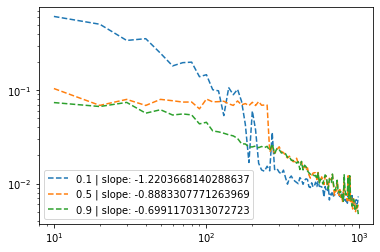

In [8]:
slope0, intercept0 = np.polyfit(np.log(xAxis), np.log(errs[0][:-1]), 1)
slope1, intercept1 = np.polyfit(np.log(xAxis), np.log(errs[1][:-1]), 1)
slope2, intercept2 = np.polyfit(np.log(xAxis), np.log(errs[2][:-1]), 1)


#txt="radius: " + str((radius)/10) + "  |  slope: " + str(slope)
#plt.figtext(0.5, 1, txt, wrap=True, horizontalalignment='center', fontsize=15)
plt.loglog(xAxis[:],errs[0][:-1], '--', label = '0.1 | slope: ' + str(slope0))
plt.loglog(xAxis[:],errs[1][:-1], '--', label = '0.5 | slope: ' + str(slope1))           
plt.loglog(xAxis[:],errs[2][:-1], '--', label = '0.9 | slope: ' + str(slope2))           
plt.legend()

#fig.savefig('../output/Logl2Error' + str(1002) + 'Nodes.png', dpi=fig.dpi)